# FCPG Test Notebook

This notebook facilitates testing the the core functionality of the FCPG tools. This steps through providing input data, converting ESRI flow directions to TauDEM flow direction, resampling and reprojecting input data, generating upstream FCPGs, creating a dictionary to cascade values from upstream to downstream hydrologic units, updating downstream parameter grids, accumulating updated grids, and making FCPGs corrected for an upstream area. The last section verifies the handling of no data values if that is desired by the user.

This notebook reads data from `./test_data` and writes data to `./test_output`. `./test_output` can be discarded after testing is complete.

Input and output grids can be examined in either ArcGIS or QGIS.

In [1]:
import FCPGtools as fc
import os
import rasterio as rs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Verbose output
verbose = True

def plot(fl, cmap='Blues'): # define a helper plotting function
    src = rs.open(fl)
    tmp = src.read(1)
    try:
        tmp[tmp == src.nodata] = np.NaN
    except:
        pass
    plt.figure(figsize = (10,10))
    plt.imshow(tmp, cmap = cmap)
    
print('FCPGtools version %s loaded from %s'%(fc.__version__,fc.__path__[0]))

FCPGtools version 0.9.12 loaded from /mnt/c/Users/tbarnhart/projects/FCPGtools/FCPGtools


In [2]:
# input data sets
upstreamFDR = os.path.join('.','test_data','validation_upstream_fdr.tif') # upstream area FDR grid
downstreamFDR = os.path.join('.','test_data','validation_downstream_fdr.tif') # downstream area FDR grid
upstreamWBD = gpd.read_file(os.path.join('.','test_data/upstream_wbd.shp')) # upstream WBD subset to test cascading parameters


# parameter datasets
P = os.path.join('.','test_data','validation_daymet_an_P_2017.tif') # daymet annual P for 2017
LC = os.path.join('.','test_data','NALCMS_2015.tif') # North America Land Cover 2015

testFolder = os.path.join('.','test_output') # folder to store outputs

In [3]:
# reproject the WBD to the grid CRS
tmp = rs.open(upstreamFDR)
dstCRS = tmp.crs.to_proj4()

upstreamWBD.to_crs(crs=dstCRS, inplace=True)

In [4]:
if os.path.exists(testFolder) == False: # make test output location if it doesn't exist, this directory can be deleted later
    os.mkdir(testFolder)

## Convert ESRI FDR to TauDEM FDR

In [5]:
# define output paths
upstreamFDRTau = os.path.join(testFolder,'upstreamFDRtau.tif')
downstreamFDRTau = os.path.join(testFolder,'downstreamFDRtau.tif')

In [6]:
# reclassify ESRI drainage directions to TauDEM
fc.tauDrainDir(upstreamFDR, upstreamFDRTau, verbose=verbose)
fc.tauDrainDir(downstreamFDR, downstreamFDRTau, verbose=verbose)

Reclassifying Flow Directions...
TauDEM drainage direction written to: ./test_output/upstreamFDRtau.tif
Reclassifying Flow Directions...
TauDEM drainage direction written to: ./test_output/downstreamFDRtau.tif


## Resample Daymet and Land Cover

In [7]:
# define output paths
Pupstream = os.path.join(testFolder,'Pup.tif')
Pdownstream = os.path.join(testFolder,'Pdwn.tif')
LCupstream = os.path.join(testFolder,'LCup.tif')
LCdownstream = os.path.join(testFolder,'LCdwn.tif')

In [8]:
fc.resampleParam(P,upstreamFDRTau, Pupstream, forceProj = True, verbose=verbose) # resample and crop daymet upstream
fc.resampleParam(P,downstreamFDRTau,Pdownstream, forceProj = True, verbose=verbose) # downstream
fc.resampleParam(LC, downstreamFDRTau, LCdownstream, forceProj = True, verbose=verbose)
fc.resampleParam(LC, upstreamFDRTau, LCupstream, forceProj = True, verbose=verbose)

Flow Direction Proj4: "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"
Parameter Proj4:PROJCS["Lambert_Conformal_Conic_2SP",GEOGCS["GCS_unknown",DATUM["D_unknown",SPHEROID["Spheroid",6378137,298.25723]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",42.5],PARAMETER["central_meridian",-100],PARAMETER["standard_parallel_1",25],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Flow Direction Xsize:30.0
Parameter Xsize:1000.0
Resampling and Reprojecting Parameter Raster...
gdalwarp -overwrite -tr 30.0 30.0 -t_srs "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs" -te -1384004.9999999995 1635194.9999999963 -1354064.9999999995 16

## Binarize Land Cover

In [9]:
usLCbinary = fc.cat2bin(LCupstream, testFolder, verbose=verbose)
dsLCbinary = fc.cat2bin(LCdownstream, testFolder, verbose=verbose)

Creating binaries for ./test_output/LCup.tif
Creating binaries for ./test_output/LCdwn.tif


## Accumulate the Upstream Area

In [10]:
upstreamFAC = os.path.join(testFolder,'upstreamFAC.tif') # path for the output FAC grid.

fc.tauFlowAccum(upstreamFDRTau,upstreamFAC, cores=4, verbose=verbose)

Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/upstreamFDRtau.tif -ad8 ./test_output/upstreamFAC.tif -nc


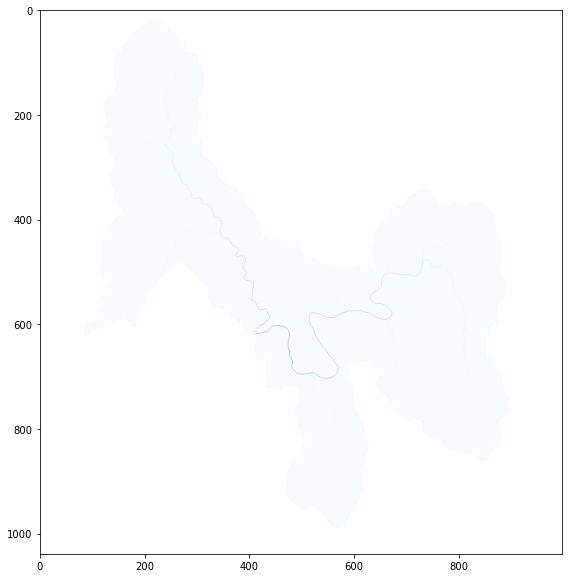

In [11]:
plot(upstreamFAC)

## Demonstration of Multiple Pour Points

The following is a demonstration of the workflow for HUC4 geospatial tiles (NHD High-Res). The update dictionary produced here is not used after this Section.

In [12]:
upstreamWBD

,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,NonContrib,NonContr_1,AreaSqKm,...,GNIS_ID,Name,States,HUC12,HUType,HUMod,ToHUC,Shape_Leng,Shape_Area,geometry
0,2685,{AAAE4745-7F69-4249-9EE6-61A0FDD375D2},{2E2678AC-0C9D-49CB-806B-540A9302D247},None,None,None,2013-01-18,0.0,0.0,133.04,...,0,Honey Draw-Colorado River,AZ,140700061105,S,DM,150100010303,0.805006,0.013444,"POLYGON ((-1357947.568 1651035.025, -1357949.2..."
1,2737,{6ECBF3AC-20C7-4EA3-AF3A-F8DB61EF2BBB},{AEC557FF-82D8-4F4D-BF0D-2BF431714390},None,None,None,2017-10-25,0.0,0.0,90.55,...,0,Johnson Point-Paria River,"AZ,UT",140700070706,S,NM,150100010303,0.612730,0.009157,"POLYGON ((-1377191.806 1665386.803, -1377192.3..."


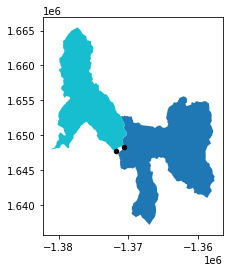

In [13]:
pourBasins = fc.makePourBasins(upstreamWBD,'1407','1501')
pourPts = fc.findPourPoints(pourBasins,upstreamFAC, upstreamFDRTau, plotBasins=True)

In [14]:
pourPts

[(-1370669.9999999995, 1648259.9999999963, 155007.0),
 (-1371809.9999999995, 1647779.9999999963, 101615.0)]

In [15]:
# create an initial dictionary for the region 14 to 15 cascade
updateDictFl = os.path.join(testFolder,'HUC1407_update.json')
upHUC = '1407'
x,y,w = zip(*pourPts) # expand the pour points

ud = fc.createUpdateDict(x,y,w,upHUC, updateDictFl, verbose = verbose)

In [16]:
ud # there are two pour points

{'1407': {'x': ['-1370669.9999999995', '-1371809.9999999995'],
  'y': ['1648259.9999999963', '1647779.9999999963'],
  'maxUpstreamFAC': ['155007.0', '101615.0'],
  'vars': ['maxUpstreamFAC']}}

## Find Pour Point to Downstream Area

In [17]:
# find the single pour point between region 14 and region 15.
x,y,d,w = fc.findLastFACFD(upstreamFAC, fl = upstreamFAC) # locate max FAC value.
x,y,f,w = fc.findLastFACFD(upstreamFAC, fl = upstreamFDRTau) # Get flow direction of above point

In [18]:
# create an initial dictionary for the region 14 to 15 cascade
updateDictFl = os.path.join(testFolder,'HUC14_update.json')
upHUC = '14'
ud = fc.createUpdateDict([x],[y],[d],upHUC, updateDictFl, verbose = verbose)

## FCPG Upstream Daymet and Land Cover

In [19]:
usLCbinary.append(Pupstream) # append the Daymet path to the land cover binary grids

In [ ]:
accumParams = fc.accumulateParam_batch(usLCbinary,upstreamFDRTau,testFolder,cores = 4, verbose = verbose)

In [ ]:
upstream_cpgs = fc.make_fcpg_batch(accumParams,upstreamFAC,testFolder, verbose = verbose)

### Create Update Dictionary with FCPG Values

In [ ]:
# Update the dictionary with values from the upstream accumulated parameters, this should probably be a v2 function...
for fl in accumParams: # iterate through the accumulated parameters
    print(fl)
    # Parse the file names into variable names... 
    varname = fl.split('/')[-1].split('up')[0]
    if varname == 'LC':
        mod = fl.split('/')[-1].split('up')[-1].split('accum')[0]
        var = varname+mod
    else:
        var = varname
    
    # Query accumualted raster for values
    
    val = str(fc.queryPoint(x,y,fl))

    ud = fc.updateDict(updateDictFl,'14',var,[val])    

## Cascade to Downstream Area

In [ ]:
downstreamFACadj = os.path.join(testFolder,'downstreamFACadj.tif')
downstreamFACweight = os.path.join(testFolder,'downstreamFACweight.tif')
fc.adjustFAC(downstreamFDRTau,downstreamFACweight,updateDictFl,downstreamFDRTau,downstreamFACadj, cores = 4, verbose = verbose)

In [ ]:
dsLCbinary.append(Pdownstream) #add the precip into the downstream land cover files

In [ ]:
# create updated, unaccumulated parameter grids for the downstream region
adjDSparams = []
for fl,inGrid in zip(accumParams,dsLCbinary): # iterate through the accumulated parameters
    # Parse the file names into variable names... 
    varname = fl.split('/')[-1].split('up')[0]
    if varname == 'LC':
        mod = fl.split('/')[-1].split('up')[-1].split('accum')[0]
        var = varname+mod
    else:
        var = varname
    
    outfl = inGrid.split('.tif')[0]+'adj.tif'

    fc.adjustParam(var,inGrid,updateDictFl,outfl, verbose = verbose)
    adjDSparams.append(outfl)

In [ ]:
# accumulate the downstream parameter grids
DSaccum = fc.accumulateParam_batch(adjDSparams,downstreamFDRTau,testFolder, cores=4, verbose = verbose)

In [ ]:
# accumulate the downstream area
dsFCPG = fc.make_fcpg_batch(DSaccum,downstreamFACadj,testFolder, verbose = verbose)

## Insert NoData values into Daymet and Verify FCPG NoData Behavior 

In [ ]:
with rs.open(upstreamFDR) as src:
    fdr = src.read(1)
    fdr[fdr == src.nodata] = 0
    fdr[fdr != 0] = 1
    mask = fdr.astype(np.uint)


In [ ]:
plt.imshow(mask)

In [ ]:
#make row,col vectors of where to insert nodata values

size = 1000 # number of no data values to insert

idCol,idRow = np.where(mask == 1) # get locations of all points within the watershed

cols = np.random.choice(idCol,size = size,replace = False)
rows = np.random.choice(idRow, size = size, replace = False)

In [ ]:
PupstreamNoData = os.path.join(testFolder,'PupNoData.tif') # output file name

# open source
with rs.open(Pupstream) as src:
    meta = src.meta
    noData = src.nodata
    P = src.read(1)

P[cols,rows] = noData # insert nodata values

# write out updated P grid
with rs.open(PupstreamNoData,'w',**meta) as dst:
    dst.write(P,1)

In [ ]:
plt.imshow(P)

In [ ]:
# accumualte the P raster with no data values added and produce the noData grids

accumRast = os.path.join(testFolder,'PupNoData_accum.tif')
outNoDataAccum = os.path.join(testFolder,'PupNoData_accumNoData.tif')
outNoData = os.path.join(testFolder,'PupNodataRast.tif')
outNoDataZero = os.path.join(testFolder,'PupNoDataZero.tif')

fc.accumulateParam(PupstreamNoData, upstreamFDRTau, accumRast,
                   outNoDataRast = outNoData, outNoDataAccum=outNoDataAccum,
                   zeroNoDataRast = outNoDataZero ,cores = 4, verbose = verbose)

In [ ]:
# make a FCPG accounting for noData
outRast = os.path.join(testFolder,'Pup_FCPG_noData.tif')

fc.make_fcpg(accumRast,upstreamFAC, outRast, noDataRast=outNoDataAccum, verbose = verbose)

## Decay FCPG

Produce a FCPG where values are decayed based on their distance to a stream, this can be useful for producing FCPGs with more localized values rather than basin-average values.

In [ ]:
upstreamFDRTauDinf = os.path.join(testFolder,'upstreamFDRDinf.tif') # D-infinity flow direction raster
fc.d8todinfinity(upstreamFDRTau, upstreamFDRTauDinf, verbose = verbose) # convert D8 flow directions to D-inf flow directions

In [ ]:
streamDistRast = os.path.join(testFolder,'upstreamDist2Stream.tif') # distance to stream raster
streamRast = os.path.join(testFolder,'upstreamSTR900.tif') # stream raster
fc.makeStreams(upstreamFAC, streamRast, verbose = verbose)
fc.dist2stream(upstreamFDRTau, upstreamFAC, 900, streamDistRast, cores = 4, verbose = verbose) # compute distance to streams, use 900 cells as accumulation threshold 

In [ ]:
decayRast = os.path.join(testFolder,'upstreamDecay.tif')
k = 4 # decay coefficient
fc.makeDecayGrid(streamDistRast, k, decayRast, verbose = verbose)
plot(decayRast, cmap = 'Greens')

In [ ]:
decayFAC = os.path.join(testFolder,'decayAccum.tif') # decay accumulation grid
decayParam = os.path.join(testFolder,'decayP.tif') # decay parameter accumulation grid

fc.decayAccum(upstreamFDRTauDinf, decayRast, decayParam, # perform the parameter decay accumulation
              paramRast = Pupstream, cores = 4, verbose = verbose)

In [ ]:
decayFCPG = os.path.join(testFolder,'decayFCPG.tif')
fc.maskStreams(decayParam, streamRast, decayFCPG, verbose = verbose) #Mask out pixels not on streamlines